# 5_01 - MODELO CLASIFICACIÓN CON EL **LABEL PROPAGATION**

En este notebook vamos a crear los pipeline de entrenamiento y ejecución.

## IMPORTACIÓN DE PAQUETES

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scikitplot as skplt 

#transformación de datos
from sklearn.preprocessing import OrdinalEncoder

#modelo

from sklearn.semi_supervised import LabelPropagation

#metricas de evaluación
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Crear Pipeline
from sklearn.pipeline import make_pipeline

import cloudpickle

## IMPORTAR LOS DATOS

In [2]:
df = pd.read_csv('../../02_Datos/03_Trabajo/tablon_analitico.csv', index_col= 0)
df

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,target
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB
5,A,A,P,P,P,A,NB
...,...,...,...,...,...,...,...
178,A,P,N,A,N,N,B
179,N,N,N,P,N,P,B
182,N,N,N,P,N,N,B
215,N,A,P,A,N,P,B


### SEPARAMOS PREDICTORAS Y TARGET

In [3]:
x = df.drop(columns= 'target').copy()
y = df.target.copy().reset_index()

## TRANSFORMACIÓN DE VARIABLES

### Variables a aplicar Ordinal Encoder

In [4]:
var_oe = ['industrial_risk',
            'management_risk',
            'financial_flexibility',
            'credibility',
            'competitiveness',
            'operating_risk']


### Orden y categoría de las variables

In [5]:
orden_industrial = ['N','A','P']
orden_management = ['N','A','P']
orden_financial = ['N','A','P']
orden_credibility = ['N','A','P']
orden_competitiveness = ['N','A','P']
orden_operating = ['N','A','P']

categorias = [orden_industrial,
              orden_management,
              orden_financial,
              orden_credibility,
              orden_competitiveness,
              orden_operating]


### Instanciar Ordinal Encoder

In [6]:
oe = OrdinalEncoder(categories= categorias, 
                    handle_unknown= 'use_encoded_value',
                    unknown_value= -99)

### Entrenar y aplicar

In [7]:
df_oe = oe.fit_transform(x[var_oe])

In [8]:
nombre_oe = [variable + '_oe' for variable in var_oe]
df_oe = pd.DataFrame(df_oe, columns= nombre_oe)
df_oe

,industrial_risk_oe,management_risk_oe,financial_flexibility_oe,credibility_oe,competitiveness_oe,operating_risk_oe
0,0.0,0.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,2.0,2.0,2.0,2.0,2.0
3,0.0,0.0,2.0,2.0,2.0,0.0
4,1.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...
86,1.0,2.0,0.0,1.0,0.0,0.0
87,0.0,0.0,0.0,2.0,0.0,2.0
88,0.0,0.0,0.0,2.0,0.0,0.0
89,0.0,1.0,2.0,1.0,0.0,2.0


## APLICAR TRANSFORMACIÓN BINARIA A LA TARGET

In [9]:
y = y.replace({'B':1 , 'NB': 0})
y.drop(columns= 'index', inplace= True)
y

,target
0,0
1,0
2,0
3,0
4,0
...,...
86,1
87,1
88,1
89,1


## AGRUPAR PREDICTORAS Y TARGET EN UN DATASET

In [10]:
df_tablon = pd.concat([df_oe, y], axis= 1, ignore_index= False)
df_tablon

,industrial_risk_oe,management_risk_oe,financial_flexibility_oe,credibility_oe,competitiveness_oe,operating_risk_oe,target
0,0.0,0.0,1.0,1.0,1.0,0.0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2.0,2.0,2.0,2.0,2.0,2.0,0
3,0.0,0.0,2.0,2.0,2.0,0.0,0
4,1.0,1.0,2.0,2.0,2.0,1.0,0
...,...,...,...,...,...,...,...
86,1.0,2.0,0.0,1.0,0.0,0.0,1
87,0.0,0.0,0.0,2.0,0.0,2.0,1
88,0.0,0.0,0.0,2.0,0.0,0.0,1
89,0.0,1.0,2.0,1.0,0.0,2.0,1


### SEPARAMOS PREDICTORAS Y TARGET

In [11]:
x = df_tablon.drop(columns= 'target').copy()
y = df_tablon.target.copy().reset_index()
y.drop(columns= 'index', inplace= True)

## MODELIZAR

### CARGAR EL MEJOR MODELO CON EL ALGORITMO, PARÁMETROS Y VALORES

In [12]:
modelo = pd.read_pickle('../../04_Modelos/Best_Estimator/LabelPropagation_v0.pickle')

In [13]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo', LabelPropagation())])

In [14]:
modelo.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('algoritmo', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'algoritmo': [LabelPropagation()]},
                         {'algoritmo': [RidgeClassifier()]},
                         {'algoritmo': [RidgeClassifierCV()]},
                         {'algoritmo': [LogisticRegression()]},
                         {'algoritmo': [LGBMClassifier()]},
                         {'algoritmo': [NuSVC()]}],
             scoring='roc_auc')>

### PREDECIR SOBRE LA VALIDACIÓN

In [15]:
pred = modelo.best_estimator_.predict(x)
pred_proba = modelo.best_estimator_.predict_proba(x)[:,1]

### EVALUAR SOBRE LA VALIDACIÓN

In [16]:
v_roc_auc_proba = roc_auc_score(y, pred_proba)
v_roc_auc = roc_auc_score(y, pred)
v_accuracy = accuracy_score(y, pred)
v_report = classification_report(y, pred)

print(f"Roc AUC_proba: {v_roc_auc_proba}")
print(f"Roc AUC: {v_roc_auc}")
print(f"Accuracy: {v_accuracy}")
print(f"Classification Report:{v_report}")

Roc AUC_proba: 1.0
Roc AUC: 1.0
Accuracy: 1.0
Classification Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        25

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



## REPORTING DEL MODELO

Matrix de Confusión MultiClass

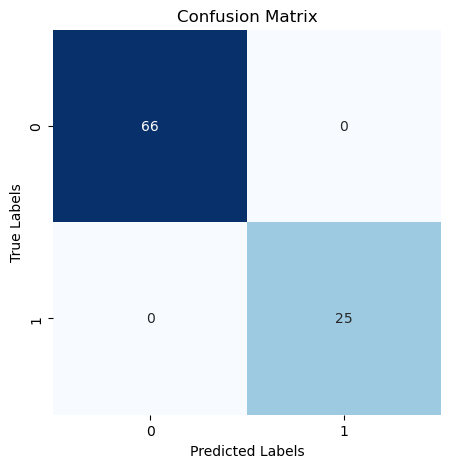

In [17]:
# Calcular la matriz de confusión
cm = confusion_matrix(y, pred)


# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Configurar etiquetas y título del gráfico
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix");


### Precision-Recall

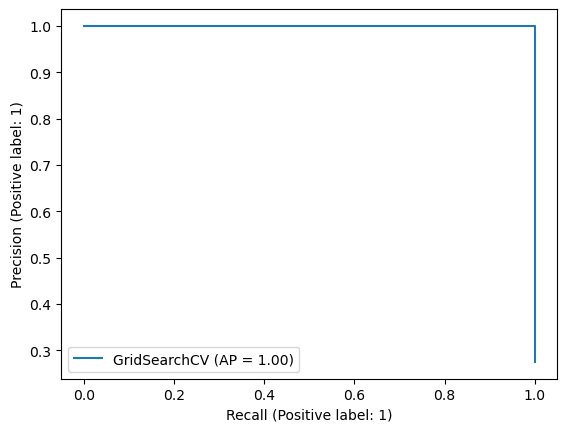

In [18]:
PrecisionRecallDisplay.from_estimator(modelo, x, y);

El mejor best_threshold: 1.0


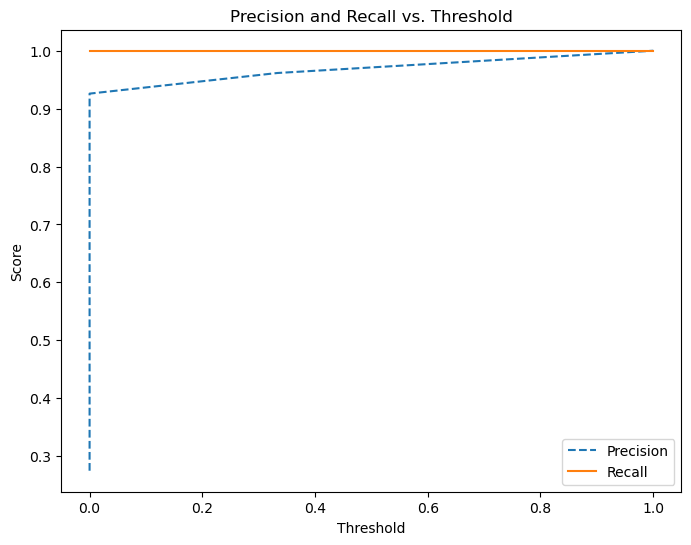

In [19]:
# Calcula la curva de precisión y recall para diferentes umbrales de corte
precision, recall, thresholds = precision_recall_curve(y, pred_proba)

# Grafica la relación entre la precisión y el recall en función del umbral de corte
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recall[:-1], label='Recall', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs. Threshold')

# Encuentra el umbral que maximiza F1-score (o ajusta según tus necesidades)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("El mejor best_threshold:", best_threshold)

### ROC Chart

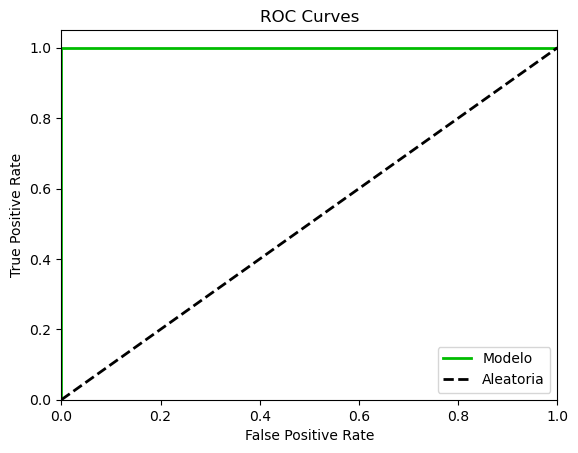

In [20]:
fig, ax = plt.subplots()

skplt.metrics.plot_roc(y, modelo.best_estimator_.predict_proba(x), ax=ax) 

#Eliminamos la línea de los ceros y personalizamos la leyenda
ax.lines[0].remove()            
ax.lines[1].remove()
ax.lines[1].remove()
plt.legend(labels = ['Modelo','Aleatoria']);

## CREAR PIPELINE DE ENTRENAMIENTO Y EJECUCIÓN

### INSTANCIAR EL MODELO

In [21]:
modelo = LabelPropagation()

### CREAR Y GUARDAR EL PIPE FINAL DE ENTRENAMIENTO

In [22]:
# Crear pipe de entrenamiento 

pipe_entrenamiento = make_pipeline(modelo)

In [23]:
# Guardar pipe de entrenamiento
nombre_pipe_entrenamiento = 'pipe_entrenamiento.pickle'
ruta_pipe_entrenamiento = '../../04_Modelos/' + nombre_pipe_entrenamiento

with open (ruta_pipe_entrenamiento, mode= 'wb') as file:
    cloudpickle.dump(pipe_entrenamiento, file)

### ENTRENAR Y GUARDAR EL PIPE DE EJECUCIÓN

In [24]:
#Entrenar pipe de entrenamiento

pipe_ejecucion = pipe_entrenamiento.fit(x,y)

c:\Users\ialca\anaconda3\envs\proyecto1\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
nombre_pipe_ejecucion = 'pipe_ejecucion.pickle'
ruta_pipe_ejecucion = '../../04_Modelos/' + nombre_pipe_ejecucion

with open (ruta_pipe_ejecucion, mode= 'wb') as file:
    cloudpickle.dump(pipe_ejecucion, file)